# Estudo de Sistemas de Equações
#### Em matemática, um conjunto de equações simultâneas, também conhecido como um sistema de equações, é um conjunto finito de equações para os quais tem uma única solução, nenhuma solução ou infinitas soluções.

In [12]:
# execute essa linha de código para importar as definições do plot_helper

import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

# interactive backends
_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
    fontsize = 4
    fig_scale = 0.75
else:
    fontsize = 5
    fig_scale = 1

grey = '#808080'
gold = '#cab18c'   # x-axis grid
lightblue = '#0096d6'  # y-axis grid
green = '#008367'  # x-axis basis vector
red = '#E31937'    # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
    def wrapper(*args, **kwargs):
        rc('font', family='serif', size=fontsize)
        rc('figure', dpi=200)
        rc('axes', axisbelow=True, titlesize=5)
        rc('lines', linewidth=1)
        func(*args, **kwargs)
    return wrapper

@set_rc
def plot_vector(vectors, tails=None):
    ''' Draw 2d vectors based on the values of the vectors and the position of their tails.
    
    Parameters
    ----------
    vectors : list.
        List of 2-element array-like structures, each represents a 2d vector.
    
    tails : list, optional.
        List of 2-element array-like structures, each represents the coordinates of the tail
        of the corresponding vector in vectors. If None (default), all tails are set at the
        origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
        vectors and tails must have the same length.
    
    Examples
    --------
    >>> v = [(1, 3), (3, 3), (4, 6)]
    >>> plot_vector(v)      # draw 3 vectors with their tails at origin
    >>> t = [numpy.array((2, 2))]
    >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
    >>> t = [[3, 2], [-1, -2], [3, 5]]
    >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails
    '''   
    vectors = numpy.array(vectors)
    assert vectors.shape[1] == 2, "Each vector should have 2 elements."  
    if tails is not None:
        tails = numpy.array(tails)
        assert tails.shape[1] == 2, "Each tail should have 2 elements."
    else:
        tails = numpy.zeros_like(vectors)
    
    # tile vectors or tails array if needed
    nvectors = vectors.shape[0]
    ntails = tails.shape[0]
    if nvectors == 1 and ntails > 1:
        vectors = numpy.tile(vectors, (ntails, 1))
    elif ntails == 1 and nvectors > 1:
        tails = numpy.tile(tails, (nvectors, 1))
    else:
        assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

    # calculate xlimit & ylimit
    heads = tails + vectors
    limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
    limit = numpy.ceil(limit * 1.2)   # add some margins
    
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue, 
                  angles='xy', scale_units='xy', scale=1)
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    axis.set_aspect('equal')

    # if xticks and yticks of grid do not match, choose the finer one
    xticks = axis.get_xticks()
    yticks = axis.get_yticks()
    dx = xticks[1] - xticks[0]
    dy = yticks[1] - yticks[0]
    base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
    loc = ticker.MultipleLocator(base=base)
    axis.xaxis.set_major_locator(loc)
    axis.yaxis.set_major_locator(loc)
    axis.grid(True, **grid_params)
    
    # show x-y axis in the center, hide frames
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
    """ A helper function to plot the linear transformation defined by a 2x2 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors. 
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    title: str, optional.
        Title of the plot.
    """
    assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)
    I = matrix[:,0]
    J = matrix[:,1]
    X = I[0]*X_ + J[0]*Y_
    Y = I[1]*X_ + J[1]*Y_
    origin = numpy.zeros(1)
        
    # draw grid lines
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
        axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)
    
    # draw (transformed) unit vectors
    if unit_vector:
        axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
        axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

    # draw optional vectors
    color_cycle = cycle([pink, darkblue, orange, purple, brown])
    if vectors:
        for vector in vectors:
            color = next(color_cycle)
            vector_ = matrix @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

    # draw optional unit circle
    if unit_circle:
        alpha =  numpy.linspace(0, 2*numpy.pi, 41)
        circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
        circle_trans = matrix @ circle
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

    # hide frames, set xlimit & ylimit, set title
    limit = 4
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['left'].set_linewidth(0.3)
    axis.spines['bottom'].set_linewidth(0.3)
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    if title is not None:
        axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a 2x2 matrix using the helper
    function plot_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
    plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')

@set_rc
def plot_linear_transformations(*matrices, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a sequence of n 2x2 matrices using the helper
    function plot_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 2x2 matrices to visualize. Accept any number of matrices.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
      
    """
    nplots = len(matrices) + 1
    nx = 2
    ny = ceil(nplots/nx)
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure, axes = pyplot.subplots(nx, ny, figsize=figsize)

    for i in range(nplots):  # fig_idx 
        if i == 0:
            matrix_trans = numpy.identity(2)
            title = 'Antes da Transformação'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'Depois de {} Trasnformação'.format(i)
            else:
                title = 'Depois de {} Transformações'.format(i)
        plot_transformation_helper(axes[i//nx, i%nx], matrix_trans, unit_vector=unit_vector, unit_circle=unit_circle, title=title)
    # hide axes of the extra subplot (only when nplots is an odd number)
    if nx*ny > nplots:
        axes[-1,-1].axis('off')
        
@set_rc
def plot_3d_transformation_helper(axis, matrix, grid=True, unit_sphere=False, title=None):
    """ A helper function to plot the linear transformation defined by a 3x3 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.
    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    
    title : str, optional.
        Title of the plot.
    """
    assert matrix.shape == (3,3), "the input matrix must have a shape of (3,3)"
    xcolor, ycolor, zcolor = '#0084b6', '#d8a322', '#FF3333'
    linewidth = 0.7
    if grid:
        grid_range = 2
        x = numpy.arange(-grid_range, grid_range+1)
        X, Y, Z = numpy.meshgrid(x,x,x)
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        for i in range(x.size):
            for j in range(x.size):
                axis.plot(X_new[:,i,j], Y_new[:,i,j], Z_new[:,i,j], color=xcolor, linewidth=linewidth)
                axis.plot(X_new[i,:,j], Y_new[i,:,j], Z_new[i,:,j], color=ycolor, linewidth=linewidth)
                axis.plot(X_new[i,j,:], Y_new[i,j,:], Z_new[i,j,:], color=zcolor, linewidth=linewidth)
    
    if unit_sphere:
        u = numpy.linspace(0, 2 * numpy.pi, 100)
        v = numpy.linspace(0, numpy.pi, 100)
        X = 1 * numpy.outer(numpy.cos(u), numpy.sin(v))
        Y = 1 * numpy.outer(numpy.sin(u), numpy.sin(v))
        Z = 1 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        axis.plot_surface(X_new, Y_new, Z_new, rstride=4, cstride=4, linewidth=0, cmap='ocean', alpha=0.6)

    if title is not None:
        axis.set_title(title)
    
    limit = 0
    if grid or unit_sphere:
        for array in (X_new, Y_new, Z_new):
            limit_ = numpy.max(numpy.abs(array))
            limit = max(limit, limit_)
    else:
        limit = 1
    axis.set_xlim(-limit, limit)
    axis.set_ylim(-limit, limit)
    axis.set_zlim(-limit, limit)
    # adjust the whitespace between ticks and axes to get a tighter plot
    for axis_str in ['x', 'y', 'z']:
        axis.tick_params(axis=axis_str, pad=-3)

@set_rc
def plot_3d_linear_transformation(matrix, grid=True, unit_sphere=False):
    """ Plot the linear transformation defined by a 3x3 matrix using the helper
    function plot_3d_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.
    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    """
    
    figsize = numpy.array([4,2]) * fig_scale
    figure = pyplot.figure(figsize=figsize)
    axis1 = figure.add_subplot(1, 2, 1, projection='3d')
    axis2 = figure.add_subplot(1, 2, 2, projection='3d')
    plot_3d_transformation_helper(axis1, numpy.identity(3), grid=grid, unit_sphere=unit_sphere, title='before transformation')
    plot_3d_transformation_helper(axis2, matrix, grid=grid, unit_sphere=unit_sphere, title='after transformation')

@set_rc
def plot_3d_linear_transformations(*matrices, grid=False, unit_sphere=False):
    """ Plot the linear transformation defined by a sequence of n 3x3 matrices using the helper
    function plot_3d_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 3x3 matrices to visualize. Accept any number of matrices. 
    grid : bool, optional.
        Whether to plot 3d grid lines, default to False.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    """
    nplots = len(matrices) + 1
    nx = 2                 # number of figures per row
    ny = ceil(nplots/nx)   # number of figures per column
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure = pyplot.figure(figsize=figsize)

    for i in range(nplots):  # fig_idx
        axis = figure.add_subplot(ny, nx, i+1, projection='3d')
        if i == 0:
            matrix_trans = numpy.identity(3)
            title = 'Antes da Transformação'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'Depois de {} Transformação'.format(i)
            else:
                title = 'Depois de {} Transformações'.format(i)
        plot_3d_transformation_helper(axis, matrix_trans, grid=grid, unit_sphere=unit_sphere, title=title)

@set_rc
def plot_basis_helper(axis, I, J, *vectors, title=None, I_label='i', J_label='j'):
    """ A helper function to plot the 2D coordinate system determined by the basis I,J.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    
    I_label, J_label : str, optional.
        Label of the new basis, default to 'i' and 'j'.
    
    title: str, optional.
        Title of the plot.
    """
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)   # grid coordinates on the new basis
    X = I[0]*X_ + J[0]*Y_   # grid coordinates on the standard basis
    Y = I[1]*X_ + J[1]*Y_
    
    # draw origin
    origin = numpy.zeros(1)
    axis.scatter(origin, origin, c='black', s=3)

    # draw grid lines of the new coordinate system
    lw_grid = 0.4
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=grey, lw=lw_grid)
        axis.plot(X[:,i], Y[:,i], c=grey, lw=lw_grid)
    
    # highlight new axes (spines)
    lw_spine = 0.7
    zero_id = numpy.where(x==0)[0][0]
    axis.plot(X[zero_id,:], Y[zero_id,:], c=gold, lw=lw_spine)
    axis.plot(X[:,zero_id], Y[:,zero_id], c=lightblue, lw=lw_spine)

    # draw basis vectors using quiver plot
    axis.quiver(origin, origin, [I[0]], [I[1]], color=gold, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=lightblue, **quiver_params)

    # draw input vector on new coordinate system
    bound = 5
    if vectors:
        for vector in vectors:
            M = numpy.transpose(numpy.vstack((I,J)))
            vector = M @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector[0]], [vector[1]], color=red, **quiver_params)
            bound = max(ceil(numpy.max(numpy.abs(vector))), bound)
    
    # hide frames, set xlimit & ylimit, set title
    axis.set_xlim([-bound, bound])
    axis.set_ylim([-bound, bound])
    axis.axis('off')
    if title is not None:
        axis.set_title(title)

    # add text next to new basis vectors
    text_params = {'ha': 'center', 'va': 'center', 'size' : 6}
    axis.text((I[0]-J[0])/2*1.1, (I[1]-J[1])/2*1.1, r'${}$'.format(I_label), color=gold, **text_params)
    axis.text((J[0]-I[0])/2*1.1, (J[1]-I[1])/2*1.1, r'${}$'.format(J_label), color=lightblue, **text_params)

@set_rc
def plot_basis(I, J, *vectors):
    """ Plot 2d vectors on the coordinates system defined by basis I and J using the helper funtion
    plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    """
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    plot_basis_helper(axis, I, J, *vectors)

@set_rc
def plot_change_basis(I, J, *vectors):
    """ Create a side-by-side plot of some vectors both on the standard basis and on the new basis
    defined by I and J, using the helper function plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    M = numpy.transpose(numpy.vstack((I,J)))
    M_inv = inv(M)
    vectors_ = [ M_inv @ vector.reshape(-1, 1) for vector in vectors ]
    plot_basis_helper(axis1, numpy.array([1,0]), numpy.array([0,1]), *vectors, title='standard basis')
    plot_basis_helper(axis2, I, J, *vectors_, title='new basis', I_label='a', J_label='b')

@set_rc
def plot_eigen(matrix):
    """ Visualize the eigendecomposition of a 2x2 matrix as a combination of changing basis 
    and scaling transformation, using the helper function plot_basis_helper().
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    """
    figsize = numpy.array([4,4]) * fig_scale
    figure, axes = pyplot.subplots(2, 2, figsize=figsize)
    
    eigenvalues, eigenvectors = eig(matrix)
    C = eigenvectors
    D = numpy.diag(eigenvalues)
    C_inv = inv(C)

    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))

    plot_basis_helper(axes[0,0], numpy.array([1,0]), numpy.array([0,1]), title=r'coords in standard basis $\mathbf{x}$')
    plot_basis_helper(axes[0,1], C[:,0], C[:,1], title=r'change to new basis $C^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,0], C[:,0], C[:,1], title=r'scale along new basis $DC^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,1], numpy.array([1,0]), numpy.array([0,1]), title=r'change back to standard basis $CDC^{-1}\mathbf{x}$')

    circle_trans = matrix @ circle
    for axis in axes[0]:
        axis.plot(circle[0], circle[1], color=red, lw=0.8)
    for axis in axes[1]:
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

if __name__ == "__main__":
    pass

# funções definidas por L Barba e T Wang para uma apresentação no evento SciPy 2019 
# aplicação das funções para a aula do professor Edmar Candeia Gurjão feitas por Alysson Machado

import numpy # importando a biblioteca numpy do Python
%matplotlib notebook
%matplotlib inline 
from matplotlib import pyplot # importando a biblioteca matplotlib do Python

import sys # importa as definições feitas no plot_helper
sys.path.append('../scripts/')

# Ao importar, teremos acesso as funções: 
# plot_vector, plot_linear_transformation, plot_linear_transformations

#### Matrizes como Sistemas de Equações

Podemos ter o seguinte sistema de equações:
$$x + y = 1$$
$$-x + y = 5$$

e expressá-los com o uso de matrizes:

$\begin{bmatrix}
             1 & 1 \\
             -1 & 1 \\
             \end{bmatrix} $ . $\begin{bmatrix}
                                            x \\
                                            y \\
                                            \end{bmatrix}$ = $\begin{bmatrix}
                                                                          1 \\
                                                                          5 \\
                                                                          \end{bmatrix}$

Pode-se descobrir as incógnitas utilizando os seguintes métodos:

$$A.X = B$$
$$X = A^{-1}B$$

Vamos encontrar um possível valor para as variáveis x e y, utilizando o método acima já discutido em progamas anteriores.

In [13]:
# definindo uma matriz matrizA
matrizA = numpy.array([[1,1],[-1,1]]) 
# definindo uma matriz matrizB
matrizB = numpy.array([[1],[5]]) 

In [15]:
# imprime a matrizA
print("A matriz ampliada A é:\n\n", matrizA) 

A matriz ampliada A é:

 [[ 1  1]
 [-1  1]]


In [17]:
#imprime a matrizB
print("A matriz B é:\n\n", matrizB)

A matriz B é:

 [[1]
 [5]]


In [18]:
# define a matriz inversa matrizA_inversa de matrizA
matrizA_inversa = numpy.linalg.inv(matrizA)

In [19]:
# imprime a matriz inversa de A
print("A matriz inversa de A é:\n\n", matrizA_inversa)

A matriz inversa de A é:

 [[ 0.5 -0.5]
 [ 0.5  0.5]]


In [20]:
# faz a multiplicação da matriz inversa matrizA_inversa com a matrizB
(x,y) = numpy.dot(matrizA_inversa, matrizB) 

E desse modo, temos como valor de x e y:

In [21]:
# inprime os coeficientes x e y da função
print("x = {} e y = {}".format(int(x), int(y))) 

x = -2 e y = 3


Logo, temos duas equações:
$$y = 1 - x$$
$$y = 5 + x$$
Com elas podemos usar representações gráficas para analisar os resultados do sistema. Para esse fim, temos a ideia de que:

Os gráficos destas equações são retas, digamos $l_{1}$ e $l_{2}$. Como um ponto (x,y) está na reta se, e somente se, os números x e y satisfazem a equação da reta, as soluções do sistema de equações correspondem a pontos de corte $l_{1}$ e $l_{2}$. Existem três possibilidades:

> As retas $l_{1}$ e $l_{2}$ podem ser paralelas, caso em que não há interseção e consequentemente não existe nenhuma solução do sistema.

> As retas $l_{1}$ e $l_{2}$ podem cortar-se em um único ponto, caso em que o sistema tem exatamente uma solução.

> As retas $l_{1}$ e $l_{2}$ podem coincidir, caso em que existe uma infinidade de soluções.

 Vamos agora ver como se dá o comportamento gráfico das duas equações:
$$y = 1 - x$$
$$y = 5 + x$$

Text(0.5, 1.0, 'Gráfico que relaciona y em função de x')

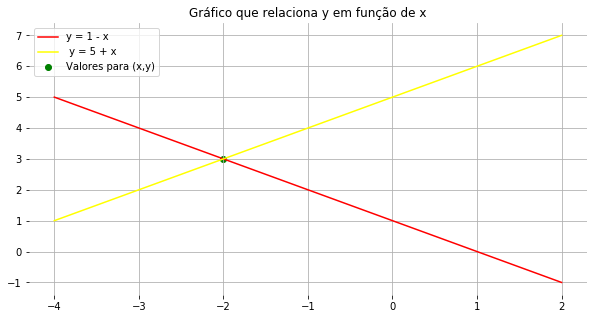

In [24]:
# define valores arbitrários para  a variável x, entre -4 e 2
valoresX = numpy.linspace(-4,2) 
# coordenadas associadas ao x
x1, x2 = -1, 1 
# valor resultante da operação do sistema 
b1, b2 = 1, 5 
# definindo o tamanho da figura
pyplot.figure(figsize=(10,5)) 
# plota a primeira reta y = 1 - x 
pyplot.plot(valoresX, x1 * valoresX + b1, color = "Red", label = "y = 1 - x ") 
# plota a segunda reta y = 5 + x  
pyplot.plot(valoresX, x2 * valoresX + b2, color = "Yellow", label = " y = 5 + x")  
# adiciona o ponto de interseção entre as retas
pyplot.scatter(x, y, color = "Green", label = "Valores para (x,y)")
# adiciona legendas ao gráfico
pyplot.legend()
# remove a caixa preta nas bordas do gráfico
pyplot.box(False) 
# desenho do quadriculado do gráfico
pyplot.grid(True) 
pyplot.title("Gráfico que relaciona y em função de x")

Pode-se perceber o único valor aceitável para a variável y é y = 3, dado que so há um ponto de interseção. De mesmo modo, o único valor aceitável para x é x = -2, dado que só há um ponto de interseção.

Vamos tentar  fazer o mesmo exemplo com a seguinte matriz de coeficientes:

$\begin{bmatrix}
         4 & 7 \\
         2 & 3.5 \\
         \end{bmatrix}$

Observe que a segunda linha da matriz de coeficientes possuí a metade dos valores da primeira linha. Logo, percebe-se que são múltiplos.

In [26]:
# definindio a matriz matrizC
matrizC = numpy.array([[4,7],[2,3.5]]) 

In [27]:
# imprimindo a matrizC
print("A matriz C é:\n\n", matrizC) 

A matriz C é:

 [[4.  7. ]
 [2.  3.5]]


Vamos aplicar uma transformação linear, considerando-a como a matriz de transformação:

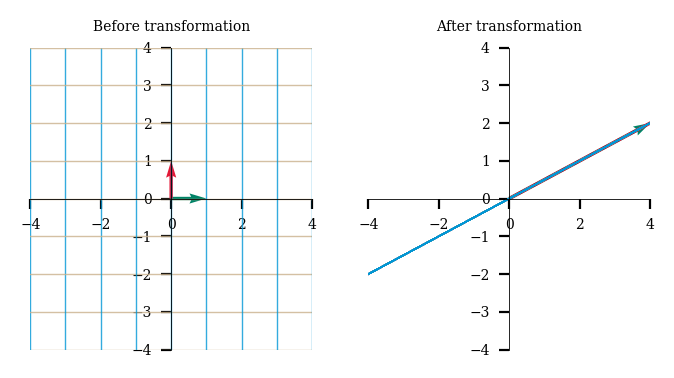

In [29]:
# aplicando a transformação linear com a matrizC
plot_linear_transformation(matrizC) 

É perceptível que os vetores são colineares.

Vamos plotar o seu gráfico utilizando as seguintes equações de reta, levando em consideração os valores resultantes da matriz de coeficientes anteriores e valores arbitrátios $b_{1} = 1$ e $b_{2} = 5$.

São elas:
$$y = (-4x + 1) / 7$$
$$y = (-2x + 5) / 3.5$$

Vamos plotar o gráfico dessas duas retas e analisar se há interseção entre elas.

Text(0.5, 1.0, 'Gráfico de y em função de x')

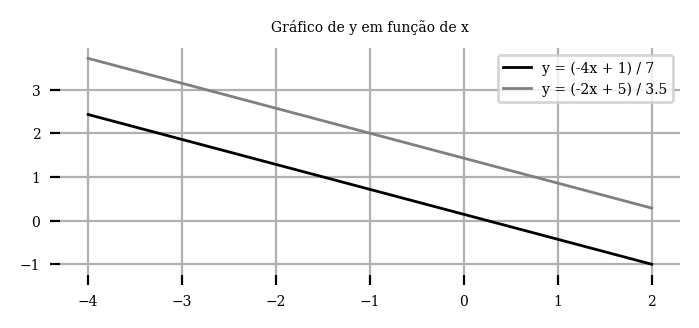

In [35]:
# define valores arbitrários para a variável x, entre -4 e 2
valoresX = numpy.linspace(-4,2) 
# coordenadas associadas a x
x1, x2 = -4 / 7, -2 / 3.5 
# valor resultante da operação do sistema
b1, b2 = 1 / 7, 5 / 3.5 
# definindo o tamanho da figura
pyplot.figure(figsize = (4,1.5)) 
# plota a primeira reta y = (-4x + 1) / 7
pyplot.plot(valoresX, x1 * valoresX + b1, color = "Black", label = "y = (-4x + 1) / 7") 
# plota a segunda reta y = (-2x + 5) / 3.5
pyplot.plot(valoresX, x2 * valoresX + b2, color = "Gray", label = "y = (-2x + 5) / 3.5") 
# adiciona a legenda no gráfico
pyplot.legend()
# remove a caixa preta nas bordas do gráfico
pyplot.box(False) 
# desenho do quadriculado do gráfico
pyplot.grid(True) 
# adiciona o título ao gráfico
pyplot.title("Gráfico de y em função de x")

Como era de se esperar, as retas são paralelas e não há interseção entre elas. Portanto, não há soluções para esse sistema.

Podemos usar o determinante para verificar a ideia acima.

In [36]:
determinante = numpy.linalg.det(matrizC) # definindo o determinante da matriz de coeficientes matrizC

In [37]:
print("O determinante da matriz é: {}".format(determinante)) # imprimindo o determinante.

O determinante da matriz é: 0.0


Como era esperado, quando um sistema linear possui pelo menos uma solução, seu determinante da matriz de coeficientes tem que ser diferente de zero.

#### Sistemas Lineares com mais variáveis

Nos exemplos acima, consideramos apenas duas equações em duas incógnitas, vamos ver que as mesmas três possibilidades (definições quando há uma interseção, mais interseções ou nenhuma interseção entre retas) valem para sistemas lineares arbitrários. Agora, vamos ver sistemas com 3 incógnitas.

Antes de começar, vamos ver um pouco como se dá uma transformação linear que envolvem 3 dimensões.

Temos a matriz abaixo, representando a base canônica:

$$\begin{bmatrix}
          1 & 0 & 0 \\
          0 & 1 & 0 \\
          0 & 0 & 1 \\
          \end{bmatrix}$$

In [38]:
# definindo uma matriz da base canônica
matriz = numpy.array([[1,0,0],[0,1,0],[0,0,1]]) 

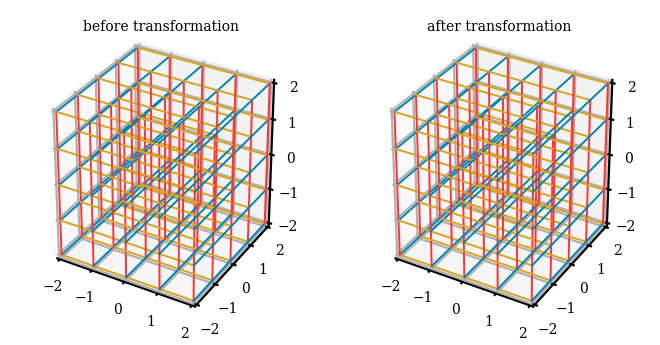

In [39]:
# plotando o gráfico da matriz de transformação
plot_3d_linear_transformation(matriz) 

Note que não houve mudanças significativas, dado que era uma transformação da base canônica para outra base canônica.

#### Exemplo: Nenhuma Variável Livre

Agora observe como ocorreria uma transformação linear de uma matriz em 3 dimensões, essa que não descreve mais a base canônica. Além disso, considerando tal matriz como uma matriz de coeficientes para um sistema linear, tal sistema teria solução e nenhhuma variável livre. Por esse motivo, a trasformação mantém um espaço vetorial de três dimensões.

Considere a matriz: 

$matriz = \begin{bmatrix}
                  1 & 0 & 1 \\
                  1 & 1 & 0 \\
                  -1 & 1 & 1 \\
                  \end{bmatrix}$

In [40]:
# definindo uma matriz
matriz_3_dimensoes = numpy.array([[1,0,1],[1,1,0],[-1,1,1]]) 

In [41]:
# imprime na tela a matriz obtida
print("A matriz é:\n\n", matriz_3_dimensoes)

A matriz é:

 [[ 1  0  1]
 [ 1  1  0]
 [-1  1  1]]


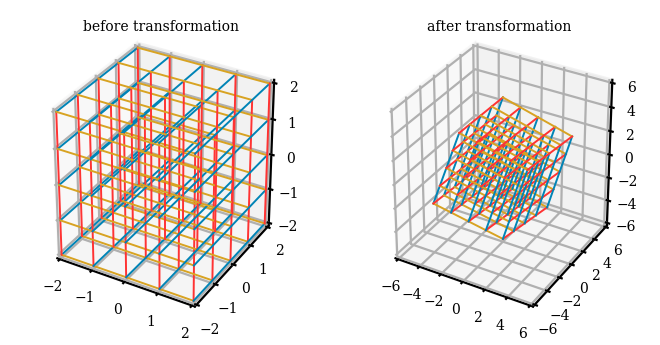

In [42]:
# plotando o gráfico da matriz de transformação
plot_3d_linear_transformation(matriz_3_dimensoes) 

E dessa forma, pode-se averiguar que ela tem três dimensões, dado que entre as três variáveis disponíveis nenhuma é uma variável livre:

In [61]:
# verificando a dimensão do espaço vetorial
print("A dimensão do espaço vetorial é: {}".format(numpy.linalg.matrix_rank(matriz_3_dimensoes))) 

A dimensão do espaço vetorial é: 3


#### Exemplo: Uma Variável Livre

Agora vamos supor o seguinte sistema de equações:
- [x] x + 2y + 7z = 0
- [x] y + 3z = 0
- [x] -3x + y = 0

Vamos resolver metodicamente e descobrir o valor de cada componente do sistema de equações:
- **1 - ) y = 3x**
- **2 - ) 3x = - 3z**
- **3 - ) 7x = - 7z**

Assim, teremos:
- **4 - ) x = -z**
- **5 - ) y = 3x**

Assim, veja que z é uma variável livre.

então, na verdade, só temos duas equações que satisfazem o sistema. Desse modo, teremos o seguinte gráfico:

In [46]:
# definindo uma matriz
matriz_2_dimensoes = numpy.array([[1,2,7],[0,1,3],[-3,1,0]]) 

In [49]:
# imprime a matriz
print("A matriz é:\n\n", matriz_2_dimensoes)

A matriz é:

 [[ 1  2  7]
 [ 0  1  3]
 [-3  1  0]]


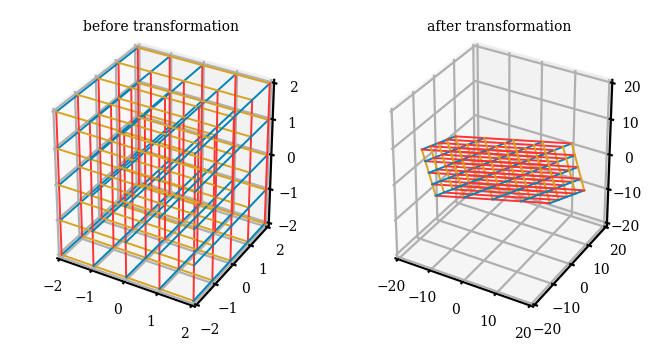

In [50]:
#plota o gráfico da matriz
plot_3d_linear_transformation(matriz_2_dimensoes) 

Como era de se esperar, dado que esse sistema tem uma variável livre entre três variáveis disponíveis, teremos um espaço vetorial de duas dimensões ao invés de três.

Comprove isso vendo que:

In [60]:
# verificando a dimensão do espaço vetorial 
print("A dimensão do espaço vetorial é:", numpy.linalg.matrix_rank(matriz_2_dimensoes)) 

A dimensão do espaço vetorial é: 2


#### Exemplo: 2 variáveis livres

Agora analisem esse sistema de equações:
- [x] x + 2y + z = 0
- [x] x - 2y  - z = 0
- [x] 3x + 6y + 3z = 0

Vamos novamente resolver metodicamente esse sistema de equações:
- **1 - ) x = -2y - z**

ou

- **2 - ) y = (-x - z) / 2**

ou

- **2 - ) y = (-x - z) / 2**

ou

- **3 - ) z = -2y - x**

E dessa forma, temos duas variáveis livres.

Vamos analisar o gráfico abaixo sobre esse respectivo sistema.

In [55]:
# definindo uma matriz
matriz_1_dimensao = numpy.array([[1,2,1],[-1,-2,-1],[3,6,3]]) 

In [56]:
# imprimindo a matriz
print("A matriz é:\n\n", matriz_1_dimensao)

A matriz é:

 [[ 1  2  1]
 [-1 -2 -1]
 [ 3  6  3]]


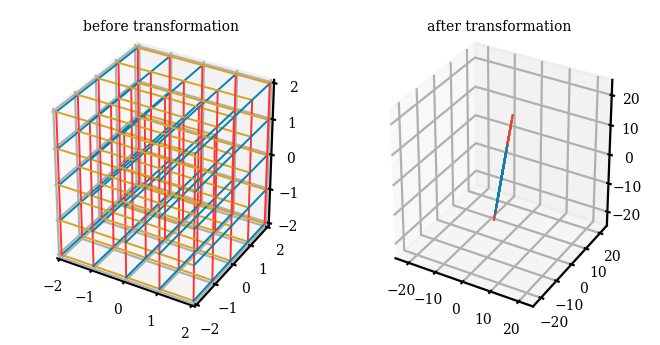

In [57]:
# plota o gráfico da matriz de transformação
plot_3d_linear_transformation(matriz_1_dimensao) 

Como era de se esperar, após toda uma análise, teremos um espaço vetorial de uma dimensão ao invés de três dimensões, dado que tal sistema linear possui duas variáveis livres entres três variáveis disponíveis.

Novamente, verifique tal afirmação abaixo:

In [59]:
# verificando a dimensão do espaço vetorial
print("A dimensão do espaço vetorial é:", numpy.linalg.matrix_rank(matriz_1_dimensao))

A dimensão do espaço vetorial é: 1


#### Funções definidas por L. Barba e T. Wang para uma apresentação no evento SciPy 2019:
###### plot_vector, plot_linear_transformation e plot_linear_transformations¶¶

|**Aprenda mais:**                                                                                                       |
|------------------------------------------------------------------------------------------------------------------------|
|- [Curso de Álgebra Linear](https://www.labma.ufrj.br/~mcabral/livros/livro-alglin/alglin-material/CursoAlgLinlivro.pdf)|
|- [Álgebra Linear - Vol 1](http://matematicaufsj.files.wordpress.com/2012/12/caderno_al_vol1.pdf)                       |